In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import PIL
from PIL import ImageFile
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms
from torch.nn import functional as F
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
% cd ~
os.chdir("Capstone/lsi/BinaryClassifierExperiment/")

/home/rcs8bg


In [3]:
# Set up data pipeline with ImageFolder class
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Training', 'Validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Validation']}
class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

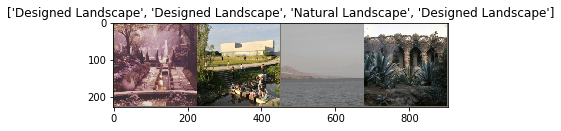

In [4]:
# Visualize some images after transformations
ImageFile.LOAD_TRUNCATED_IMAGES = True # So PIL doesn't complain about big images being cropped

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
# Learning function

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
print(device)

cuda:0


In [7]:
torch.cuda.device_count()

2

In [8]:
# Fine-tune ResNet18

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3) # Same issue as Taehon had with the curr_target must be < number targets
model = nn.DataParallel(model)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
Training Loss: 0.4141 Acc: 0.8319
Validation Loss: 0.7240 Acc: 0.7810

Epoch 1/24
----------
Training Loss: 0.3847 Acc: 0.8630
Validation Loss: 0.7272 Acc: 0.7596

Epoch 2/24
----------
Training Loss: 0.3124 Acc: 0.9011
Validation Loss: 0.9078 Acc: 0.7871

Epoch 3/24
----------
Training Loss: 0.2902 Acc: 0.8990
Validation Loss: 1.0504 Acc: 0.7810

Epoch 4/24
----------
Training Loss: 0.2798 Acc: 0.9141
Validation Loss: 0.8423 Acc: 0.7825

Epoch 5/24
----------
Training Loss: 0.2453 Acc: 0.9246
Validation Loss: 1.2072 Acc: 0.7611

Epoch 6/24
----------
Training Loss: 0.2274 Acc: 0.9321
Validation Loss: 0.7621 Acc: 0.7749

Epoch 7/24
----------
Training Loss: 0.2370 Acc: 0.9325
Validation Loss: 1.3069 Acc: 0.7871

Epoch 8/24
----------
Training Loss: 0.1575 Acc: 0.9589
Validation Loss: 0.8587 Acc: 0.7933

Epoch 9/24
----------
Training Loss: 0.1578 Acc: 0.9568
Validation Loss: 1.0090 Acc: 0.7902

Epoch 10/24
----------
Training Loss: 0.1358 Acc: 0.9656
Validation Lo

In [10]:
os.getcwd()

'/project/sds-capstone-aaai/lsi/BinaryClassifierExperiment'

In [11]:
torch.save(model_ft, "Code/LandscapeNet_imagenet_pretrained")

In [4]:
# Trying again with Places365 weights

In [8]:
arch = 'resnet18'
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)

In [9]:
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [10]:
# Reset final layer 
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
# Train
model2_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
Training Loss: 0.2776 Acc: 0.8906
Validation Loss: 0.6349 Acc: 0.8116

Epoch 1/24
----------
Training Loss: 0.2032 Acc: 0.9237
Validation Loss: 0.7555 Acc: 0.8040

Epoch 2/24
----------
Training Loss: 0.1621 Acc: 0.9430
Validation Loss: 0.7675 Acc: 0.8040

Epoch 3/24
----------
Training Loss: 0.1285 Acc: 0.9564
Validation Loss: 0.7998 Acc: 0.8070

Epoch 4/24
----------
Training Loss: 0.1141 Acc: 0.9627
Validation Loss: 1.3660 Acc: 0.8086

Epoch 5/24
----------
Training Loss: 0.1047 Acc: 0.9644
Validation Loss: 1.0075 Acc: 0.8101

Epoch 6/24
----------
Training Loss: 0.1182 Acc: 0.9606
Validation Loss: 0.9942 Acc: 0.7887

Epoch 7/24
----------
Training Loss: 0.0830 Acc: 0.9728
Validation Loss: 1.1894 Acc: 0.8040

Epoch 8/24
----------
Training Loss: 0.0537 Acc: 0.9862
Validation Loss: 1.2078 Acc: 0.8101

Epoch 9/24
----------
Training Loss: 0.0457 Acc: 0.9908
Validation Loss: 1.0249 Acc: 0.8132

Epoch 10/24
----------
Training Loss: 0.0343 Acc: 0.9929
Validation Lo

In [14]:
torch.save(model2_ft, "Code/LandscapeNet_places365pretrained")

 @article{zhou2017places,
   title={Places: A 10 million Image Database for Scene Recognition},
   author={Zhou, Bolei and Lapedriza, Agata and Khosla, Aditya and Oliva, Aude and Torralba, Antonio},
   journal={IEEE Transactions on Pattern Analysis and Machine Intelligence},
   year={2017},
   publisher={IEEE}
 }